# Gesture Recognition
<b> Use Tensorflow 2.10.0 </b>

## 1. Data Loader and Analysis

In [26]:
# import library
import os, glob, shutil
import numpy as np
import datetime
import tensorflow as tf
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from keras.layers import Dense, Dropout, Conv3D, Input, MaxPool3D, Flatten, Activation, \
                         TimeDistributed, BatchNormalization, MaxPooling2D, LSTM, GRU, Conv2D, MaxPooling3D
from keras.regularizers import l2
from keras.models import Model, Sequential

# set random seed for whole project
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
# setting global parameter
data_folder = './data'
checkpoints_folder = './checkpoints'

# setting hyparameter for project
batch_size = 8
num_epochs = 50
dest_size = (128, 128)

### 1.1 Read CSV file

In [3]:
train_doc = np.random.permutation(open('./data/train.csv').readlines())
val_doc = np.random.permutation(open('./data/val.csv').readlines()) 
train_df = pd.read_csv(os.path.join(data_folder, 'train.csv'), delimiter=';', names=['video', 'label (text)', 'label'])
val_df   = pd.read_csv(os.path.join(data_folder, 'val.csv'), delimiter=';', names=['video', 'label (text)', 'label'])
print('Total train samples :', len(train_df))
print('Total val samples   :', len(val_df))

Total train samples : 663
Total val samples   : 100


In [4]:
# take a look at train and val
print(train_df.head(5))
print(val_df.head(5))

                                      video    label (text)  label
0  WIN_20180925_17_08_43_Pro_Left_Swipe_new  Left_Swipe_new      0
1  WIN_20180925_17_18_28_Pro_Left_Swipe_new  Left_Swipe_new      0
2  WIN_20180925_17_18_56_Pro_Left_Swipe_new  Left_Swipe_new      0
3  WIN_20180925_17_19_51_Pro_Left_Swipe_new  Left_Swipe_new      0
4  WIN_20180925_17_20_14_Pro_Left_Swipe_new  Left_Swipe_new      0
                                      video    label (text)  label
0  WIN_20180925_17_17_04_Pro_Left_Swipe_new  Left_Swipe_new      0
1  WIN_20180925_17_43_01_Pro_Left_Swipe_new  Left_Swipe_new      0
2  WIN_20180925_18_01_40_Pro_Left_Swipe_new  Left_Swipe_new      0
3  WIN_20180925_18_03_21_Pro_Left_Swipe_new  Left_Swipe_new      0
4  WIN_20180926_16_46_22_Pro_Left_Swipe_new  Left_Swipe_new      0


In [5]:
# create a labels dict with key is numberic and labels is text
label_dict = {
    0 : 'Left Swipe',
    1 : 'Right Swipe',
    2 : 'Stop',
    3 : 'Thumbs Down',
    4 : 'Thumbs Up',
}

### 1.2 Analysis data

<AxesSubplot:xlabel='label', ylabel='count'>

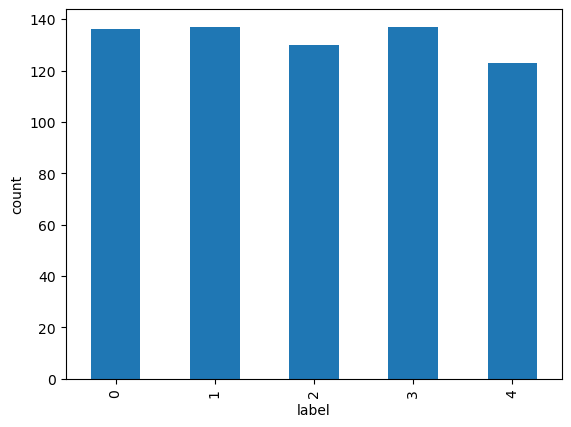

In [6]:
data = train_df.groupby('label').size()
data.plot.bar(xlabel='label', ylabel='count')

<AxesSubplot:xlabel='label', ylabel='count'>

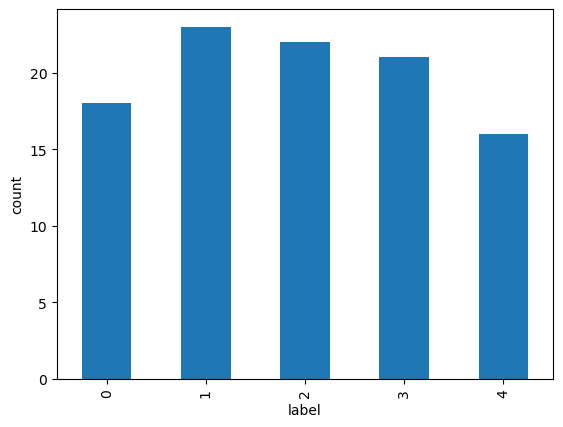

In [7]:
data = val_df.groupby('label').size()
data.plot.bar(xlabel='label', ylabel='count')

Conclusion:
<li> Data is quite balance in class </li>

### 1.3 Data Generator and Transform
Cause data is left and right sensitive, up and down sensitive, so it would be better to not clip, rotate it in spatial
Cause data is sequence, so we should not random choose the frame order

We can change the contrast and brightness of image
https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html

In [9]:
def resize_img(im, desired_size = dest_size[0]):
    """
        Resize image with keep aspect ratio
    """
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_im

def change_brightness(image):
    alpha = np.random.uniform(0.75, 1.25)
    beta = np.random.uniform(0, 100)
    new_image = np.zeros(image.shape, image.dtype)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
    return new_image

def add_noise(image, threshold = 70):
    """
        Add salt and pepper noise if get random int > threshold
    """
    random_value = np.random.randint(0, 100)
    if random_value > threshold:
        image = image/255.0
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        out = image*255
        return out
    else:
        return image

In [10]:
from imageio import imread
from skimage.transform import resize

def generator(source_path, folder_list, batch_size, augmentation = False):
    img_idx = [x for x in range(0,30,2)]#create a list of image numbers you want to use for a particular video, we are not using all the 30 images in a video, selected pickup of images
    while True:
        t = np.random.permutation(folder_list)
        num_batches =int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x=len(img_idx)
            y=dest_size[0]
            z=dest_size[1]
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            cnt_img=0
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) # read all the images in the folder
                cnt_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    if augmentation:
                        image = change_brightness(image)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image=resize_img(image)
                    image=image/255.0
                    
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        cnt_img=0
        batch_cover = num_batches*batch_size
        rem = len(t) - batch_cover
        if(len(t)!=batch_cover):
            batch_data = np.zeros((rem,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem):
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + batch_cover].split(';')[0])) # read all the images in the folder
                cnt_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in  
                    image = cv2.imread(source_path+'/'+ t[folder + batch_cover].strip().split(';')[0]+'/'+imgs[item])
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image=resize_img(image)
                    image=image/255.0
                    
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + batch_size].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = './data/train'
val_path = './data/val'
num_train_sequences = len(train_df)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_df)
print('# validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model buiding

In [12]:
def train_model(model, name, num_epochs = num_epochs, batch_size = batch_size, load_lastest = True):
    # train and val generator
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    
    # create folder for saving checkpoints
    model_name = 'model' + '_' + name

    if not os.path.exists(os.path.join(checkpoints_folder, model_name)):
        os.mkdir(os.path.join(checkpoints_folder, model_name))
    
    # optimizers
#     opt = tf.keras.optimizers.Adam(learning_rate=0.001,
#                                    beta_1=0.9,
#                                    beta_2=0.999,
#                                    epsilon=1e-07,
#                                    amsgrad=False,
#                                    name='Adam'
#                                   )
#     model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    optimiser = "Adam" #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print("###############################################")
    print("Model {} summary".format(name))
    print(model.summary())
    print("###############################################")
    
    # callbacks
    filepath = model_name + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoints_folder, model_name, filepath),
                                                                 monitor='val_loss', 
                                                                 verbose=1, 
                                                                 save_best_only=True, 
                                                                 save_weights_only=False, 
                                                                 mode='auto', 
                                                                 period=1) #chekpoints to save model in .h5
    LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, cooldown=5, verbose=1,mode='auto',min_delta=0.00001) #learning Rate
    callbacks_list = [checkpoint, LR]
    
    # calculate step_per_epoch
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1 #in case of remaining data points which are left after full batches

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1 #in case of remaining data points which are left after full batches

    # Training process
    print("###############################################")
    print("Training model")
    
    init_epoch = 0
    if load_lastest:
        model_lastest_path = sorted(glob.glob(os.path.join(checkpoints_folder, model_name, "*")))
        if len(model_lastest_path) != 0:
            model_lastest_path = model_lastest_path[-1]
            epoch_lastest = int(os.path.basename(model_lastest_path).split('-')[1])
            init_epoch = epoch_lastest
            print("Loading model from epoch:", init_epoch)
            model = tf.keras.models.load_model(model_lastest_path)
    
    history=model.fit(train_generator, 
                      steps_per_epoch=steps_per_epoch, 
                      epochs=num_epochs, verbose=1, 
                      callbacks=callbacks_list, 
                      validation_data=val_generator, 
                      validation_steps=validation_steps, 
                      class_weight=None, 
                      workers=1, 
                      initial_epoch=init_epoch)
    print("###############################################")
    return history

In [13]:
# plot accuracy & loss
def plot_history(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## 2.1 3D CNN Model

### 2.1.1 C3D
C3D inspired model

In [14]:
def Model_3D_01(nb_classes):
    """
        C3D Model
    """
    input_shape = (15, 128, 128, 3)
    weight_decay = 0.005
    nb_classes = nb_classes

    inputs = Input(input_shape)
    x = Conv3D(32,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(inputs)
    x = MaxPool3D((1,2,2),strides=(1,2,2),padding='same')(x)

    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(128,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(128, (3, 3, 3), strides=(1, 1, 1), padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(1024,activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Dense(128,activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Dense(nb_classes,kernel_regularizer=l2(weight_decay))(x)
    x = Activation('softmax')(x)

    model = Model(inputs, x, name = "3D_01")
    return model

###############################################
Model 3D_01 summary
Model: "3D_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 128, 128, 3)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 15, 128, 128, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 64, 64, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 64, 64, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 8, 32, 32, 64)    0         
 3D)                                                       

83/83 [==============================] - 19s 225ms/step - loss: 1.6192 - categorical_accuracy: 0.2036 - val_loss: 1.6158 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 13/50
83/83 [==============================] - ETA: 0s - loss: 1.6166 - categorical_accuracy: 0.1961
Epoch 13: val_loss improved from 1.61584 to 1.61253, saving model to ./checkpoints\model_3D_01\model_3D_01-00013-1.61662-0.19608-1.61253-0.24000.h5
83/83 [==============================] - 18s 223ms/step - loss: 1.6166 - categorical_accuracy: 0.1961 - val_loss: 1.6125 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 14/50
83/83 [==============================] - ETA: 0s - loss: 1.6155 - categorical_accuracy: 0.1644
Epoch 14: val_loss did not improve from 1.61253
83/83 [==============================] - 19s 225ms/step - loss: 1.6155 - categorical_accuracy: 0.1644 - val_loss: 1.6131 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 15/50
83/83 [==============================] - ETA: 0s - loss: 1.6143 - categ

Epoch 37/50
83/83 [==============================] - ETA: 0s - loss: 1.6090 - categorical_accuracy: 0.1976
Epoch 37: val_loss did not improve from 1.60546
83/83 [==============================] - 19s 224ms/step - loss: 1.6090 - categorical_accuracy: 0.1976 - val_loss: 1.6097 - val_categorical_accuracy: 0.1900 - lr: 1.0000e-04
Epoch 38/50
83/83 [==============================] - ETA: 0s - loss: 1.6090 - categorical_accuracy: 0.2097
Epoch 38: val_loss did not improve from 1.60546
83/83 [==============================] - 18s 223ms/step - loss: 1.6090 - categorical_accuracy: 0.2097 - val_loss: 1.6064 - val_categorical_accuracy: 0.2400 - lr: 1.0000e-04
Epoch 39/50
83/83 [==============================] - ETA: 0s - loss: 1.6089 - categorical_accuracy: 0.2112
Epoch 39: val_loss did not improve from 1.60546
83/83 [==============================] - 18s 224ms/step - loss: 1.6089 - categorical_accuracy: 0.2112 - val_loss: 1.6077 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 40/50
83/8

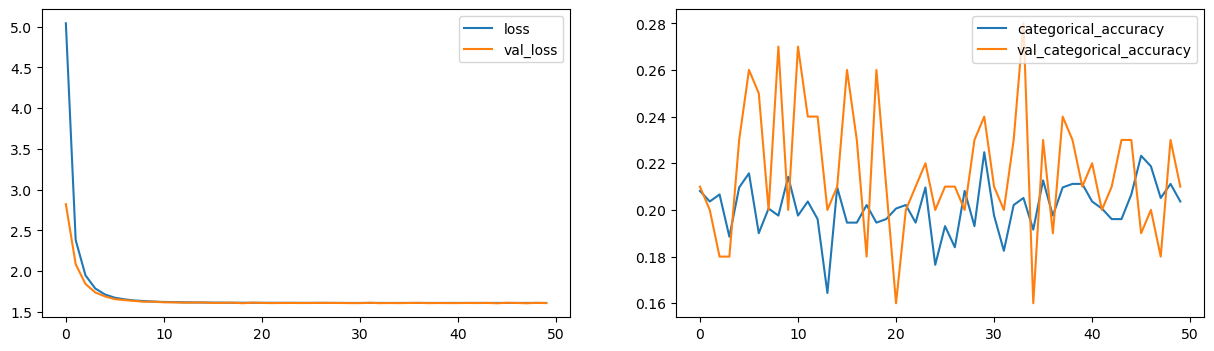

In [15]:
model = Model_3D_01(nb_classes = 5)
history = train_model(model, name = '3D_01')
plot_history(history)

Highest val_acc: at epoch 34: acc: 0.2051, val_acc: 0.2800

### 2.1.2 VGG Like 3D
What if 3D CNN go with VGG like (2 conv + 1 pool)

In [16]:
def Model_3D_02(nb_classes):
    """
        C3D Model
    """
    input_shape = (15, 128, 128, 3)
    weight_decay = 0.005
    nb_classes = nb_classes

    inputs = Input(input_shape)
    # block 1
    x = Conv3D(32,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(inputs)
    x = Conv3D(32,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((1,2,2),strides=(1,2,2),padding='same')(x)
    
    # block 2
    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    # block 3
    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)
    
    # block 4
    x = Conv3D(128,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Conv3D(128,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)
    
    # block 5
    x = Conv3D(128, (3, 3, 3), strides=(1, 1, 1), padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(1024,activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Dense(128,activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Dense(nb_classes,kernel_regularizer=l2(weight_decay))(x)
    x = Activation('softmax')(x)

    model = Model(inputs, x, name = '3D_02')
    return model

###############################################
Model 3D_02 summary
Model: "3D_02"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 128, 128, 3)  0         
                             ]                                   
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 128, 128, 32)  2624      
                                                                 
 conv3d_6 (Conv3D)           (None, 15, 128, 128, 32)  27680     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 15, 64, 64, 32)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 15, 64, 64, 64)    55360     
                                                           

Epoch 11/50
83/83 [==============================] - ETA: 0s - loss: 1.6196 - categorical_accuracy: 0.2051
Epoch 11: val_loss improved from 1.61857 to 1.61817, saving model to ./checkpoints\model_3D_02\model_3D_02-00011-1.61958-0.20513-1.61817-0.21000.h5
83/83 [==============================] - 37s 450ms/step - loss: 1.6196 - categorical_accuracy: 0.2051 - val_loss: 1.6182 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 12/50
83/83 [==============================] - ETA: 0s - loss: 1.6166 - categorical_accuracy: 0.1976
Epoch 12: val_loss improved from 1.61817 to 1.61228, saving model to ./checkpoints\model_3D_02\model_3D_02-00012-1.61655-0.19759-1.61228-0.21000.h5
83/83 [==============================] - 37s 441ms/step - loss: 1.6166 - categorical_accuracy: 0.1976 - val_loss: 1.6123 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 13/50
83/83 [==============================] - ETA: 0s - loss: 1.6150 - categorical_accuracy: 0.1916
Epoch 13: val_loss did not improve from 1.612

83/83 [==============================] - ETA: 0s - loss: 1.6091 - categorical_accuracy: 0.1946
Epoch 34: val_loss did not improve from 1.60420
83/83 [==============================] - 36s 436ms/step - loss: 1.6091 - categorical_accuracy: 0.1946 - val_loss: 1.6051 - val_categorical_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 35/50
83/83 [==============================] - ETA: 0s - loss: 1.6087 - categorical_accuracy: 0.2006
Epoch 35: val_loss did not improve from 1.60420
83/83 [==============================] - 36s 436ms/step - loss: 1.6087 - categorical_accuracy: 0.2006 - val_loss: 1.6144 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04
Epoch 36/50
83/83 [==============================] - ETA: 0s - loss: 1.6088 - categorical_accuracy: 0.2036
Epoch 36: val_loss did not improve from 1.60420
83/83 [==============================] - 36s 437ms/step - loss: 1.6088 - categorical_accuracy: 0.2036 - val_loss: 1.6062 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 37/50
83/83 [=========

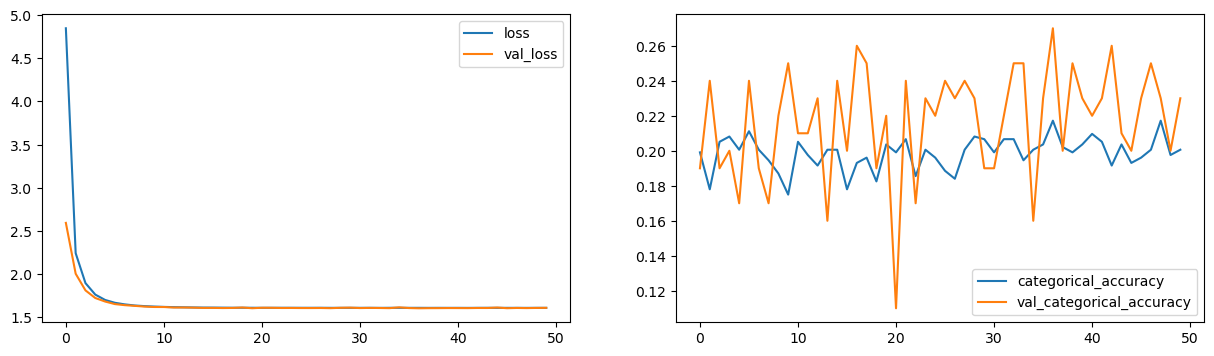

In [17]:
model = Model_3D_02(nb_classes = 5)
history = train_model(model, name = '3D_02')
plot_history(history)

Highest val_acc: at epoch 33: acc: 0.2066, val_acc: 0.2500

### 2.1.2 Custom 3D CNN Model

In [27]:
def Model_3D_03(nb_classes):
    """
        Custom 3D Model
    """
    nb_classes = nb_classes
    input_shape = (15, 128, 128, 3)
    
    model = Sequential(name = "3D_03")

    model.add(Conv3D(16, (3, 3, 3), padding = 'same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size = (2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(32, (2, 2, 2), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size = (2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size = (2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.25))


     # using Softmax as last layer
    model.add(Dense(nb_classes, activation='softmax'))
    return model


###############################################
Model 3D_03 summary
Model: "3D_03"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 15, 128, 128, 16)  1312      
                                                                 
 activation_3 (Activation)   (None, 15, 128, 128, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 15, 128, 128, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 7, 64, 64, 16)    0         
 g3D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 7, 64, 64, 16)     0         
                                                           

Epoch 13/50
83/83 [==============================] - ETA: 0s - loss: 1.4262 - categorical_accuracy: 0.6712
Epoch 13: val_loss did not improve from 1.77459
83/83 [==============================] - 18s 220ms/step - loss: 1.4262 - categorical_accuracy: 0.6712 - val_loss: 2.5105 - val_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 14/50
83/83 [==============================] - ETA: 0s - loss: 1.3984 - categorical_accuracy: 0.6697
Epoch 14: val_loss did not improve from 1.77459
83/83 [==============================] - 19s 228ms/step - loss: 1.3984 - categorical_accuracy: 0.6697 - val_loss: 2.2326 - val_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 15/50
83/83 [==============================] - ETA: 0s - loss: 1.2918 - categorical_accuracy: 0.7345
Epoch 15: val_loss did not improve from 1.77459
83/83 [==============================] - 18s 222ms/step - loss: 1.2918 - categorical_accuracy: 0.7345 - val_loss: 2.0868 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 16/50
83/83 [=========

83/83 [==============================] - ETA: 0s - loss: 1.0081 - categorical_accuracy: 0.9170
Epoch 37: val_loss did not improve from 1.20254

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
83/83 [==============================] - 18s 222ms/step - loss: 1.0081 - categorical_accuracy: 0.9170 - val_loss: 2.0219 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 38/50
83/83 [==============================] - ETA: 0s - loss: 0.8503 - categorical_accuracy: 0.9578
Epoch 38: val_loss did not improve from 1.20254
83/83 [==============================] - 19s 225ms/step - loss: 0.8503 - categorical_accuracy: 0.9578 - val_loss: 1.5218 - val_categorical_accuracy: 0.7800 - lr: 1.0000e-04
Epoch 39/50
83/83 [==============================] - ETA: 0s - loss: 0.8166 - categorical_accuracy: 0.9638
Epoch 39: val_loss did not improve from 1.20254
83/83 [==============================] - 19s 225ms/step - loss: 0.8166 - categorical_accuracy: 0.9638 - val_loss: 1.5641 - val

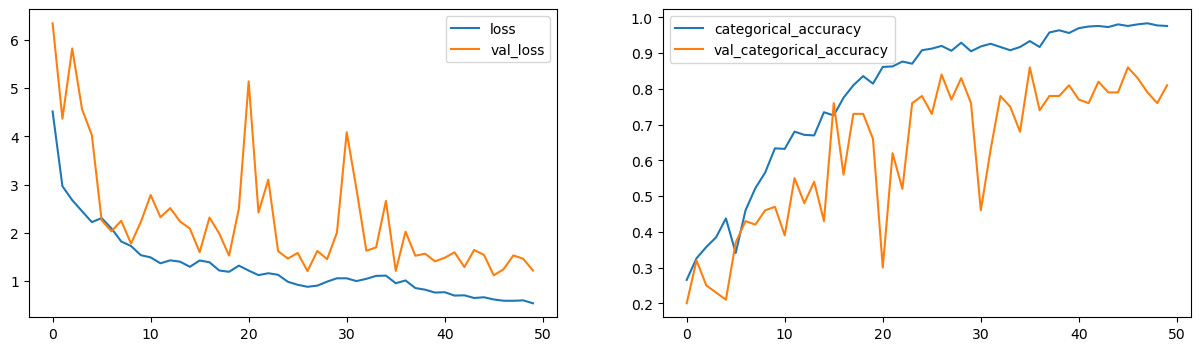

In [28]:
model = Model_3D_03(nb_classes = 5)
history = train_model(model, name = '3D_03')
plot_history(history)

Highest val_acc: at epoch 46: acc: 0.9759, val_acc: 0.8600

## 2.2 Custom 2D CNN + LTSM/GRU

### 2.2.1 Cutom 2D CNN + LSTM

In [29]:
def Model_2D_01(nb_classes):
    """
        Custom CNN with LSTM
    """
    nb_classes = nb_classes
    Input_shape_1 = (15, 128, 128, 3)
    model = Sequential(name = "2D_01")
    model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=Input_shape_1))
    model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(Dropout(0.5))
    model.add(LSTM(512, return_sequences=False, dropout=0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

###############################################
Model 2D_01 summary
Model: "2D_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 15, 64, 64, 32)   4736      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 62, 62, 32)   9248      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 15, 31, 31, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 15, 31, 31, 64)   18496     
 stributed)                                                      
                                                           

Epoch 12/50
83/83 [==============================] - ETA: 0s - loss: 1.6097 - categorical_accuracy: 0.1689
Epoch 12: val_loss did not improve from 1.60342
83/83 [==============================] - 19s 225ms/step - loss: 1.6097 - categorical_accuracy: 0.1689 - val_loss: 1.6065 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 13/50
83/83 [==============================] - ETA: 0s - loss: 1.6099 - categorical_accuracy: 0.1900
Epoch 13: val_loss did not improve from 1.60342
83/83 [==============================] - 19s 226ms/step - loss: 1.6099 - categorical_accuracy: 0.1900 - val_loss: 1.6084 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 14/50
83/83 [==============================] - ETA: 0s - loss: 1.6096 - categorical_accuracy: 0.1840
Epoch 14: val_loss did not improve from 1.60342
83/83 [==============================] - 19s 226ms/step - loss: 1.6096 - categorical_accuracy: 0.1840 - val_loss: 1.6071 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 15/50
83/83 [=========

Epoch 37/50
83/83 [==============================] - ETA: 0s - loss: 1.6088 - categorical_accuracy: 0.2051
Epoch 37: val_loss did not improve from 1.60342
83/83 [==============================] - 19s 227ms/step - loss: 1.6088 - categorical_accuracy: 0.2051 - val_loss: 1.6089 - val_categorical_accuracy: 0.2600 - lr: 1.0000e-05
Epoch 38/50
83/83 [==============================] - ETA: 0s - loss: 1.6083 - categorical_accuracy: 0.2081
Epoch 38: val_loss did not improve from 1.60342
83/83 [==============================] - 19s 226ms/step - loss: 1.6083 - categorical_accuracy: 0.2081 - val_loss: 1.6091 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-05
Epoch 39/50
83/83 [==============================] - ETA: 0s - loss: 1.6087 - categorical_accuracy: 0.2051
Epoch 39: val_loss did not improve from 1.60342
83/83 [==============================] - 18s 222ms/step - loss: 1.6087 - categorical_accuracy: 0.2051 - val_loss: 1.6083 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-05
Epoch 40/50
83/8

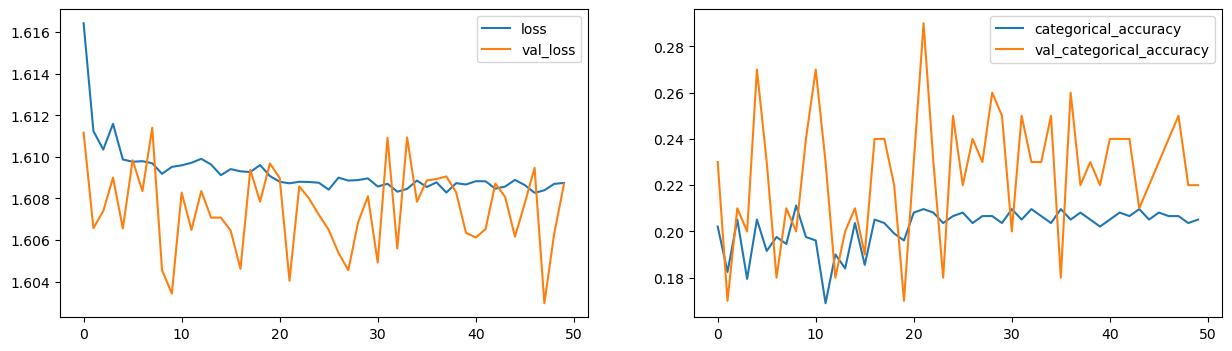

In [30]:
model = Model_2D_01(nb_classes = 5)
history = train_model(model, name = '2D_01')
plot_history(history)

Highest val_acc: at epoch 22: acc: 0.2097, val_acc: 0.2900

### 2.2.2 Custom 2D CNN +GRU

In [31]:
def Model_2D_02(nb_classes):
    """
        Custom CNN with GRU
    """
    nb_classes = nb_classes
    Input_shape_1 = (15, 128, 128, 3)
    model = Sequential(name = "2D_02")
    model.add(TimeDistributed(Conv2D(8, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=Input_shape_1))
    model.add(TimeDistributed(Conv2D(8, (3,3), kernel_initializer="he_normal", activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(Dropout(0.5))
    ## using GRU as the RNN model along with softmax as our last layer.
    model.add(GRU(512, return_sequences=False, dropout=0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    return model


###############################################
Model 2D_02 summary
Model: "2D_02"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 15, 64, 64, 8)    1184      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 15, 62, 62, 8)    584       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 15, 31, 31, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 15, 31, 31, 16)   1168      
 stributed)                                                      
                                                           

Epoch 12/50
82/83 [============================>.] - ETA: 0s - loss: 1.6104 - categorical_accuracy: 0.2012
Epoch 12: val_loss did not improve from 1.60514
83/83 [==============================] - 18s 221ms/step - loss: 1.6103 - categorical_accuracy: 0.2051 - val_loss: 1.6071 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 13/50
83/83 [==============================] - ETA: 0s - loss: 1.6103 - categorical_accuracy: 0.1900
Epoch 13: val_loss did not improve from 1.60514
83/83 [==============================] - 19s 230ms/step - loss: 1.6103 - categorical_accuracy: 0.1900 - val_loss: 1.6060 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 14/50
83/83 [==============================] - ETA: 0s - loss: 1.6102 - categorical_accuracy: 0.1900
Epoch 14: val_loss did not improve from 1.60514
83/83 [==============================] - 19s 227ms/step - loss: 1.6102 - categorical_accuracy: 0.1900 - val_loss: 1.6063 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 15/50
83/83 [=========

83/83 [==============================] - ETA: 0s - loss: 1.6085 - categorical_accuracy: 0.2081
Epoch 36: val_loss did not improve from 1.60407
83/83 [==============================] - 19s 225ms/step - loss: 1.6085 - categorical_accuracy: 0.2081 - val_loss: 1.6090 - val_categorical_accuracy: 0.1900 - lr: 1.0000e-05
Epoch 37/50
83/83 [==============================] - ETA: 0s - loss: 1.6085 - categorical_accuracy: 0.2097
Epoch 37: val_loss did not improve from 1.60407
83/83 [==============================] - 18s 223ms/step - loss: 1.6085 - categorical_accuracy: 0.2097 - val_loss: 1.6060 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-05
Epoch 38/50
83/83 [==============================] - ETA: 0s - loss: 1.6087 - categorical_accuracy: 0.2066
Epoch 38: val_loss did not improve from 1.60407
83/83 [==============================] - 18s 223ms/step - loss: 1.6087 - categorical_accuracy: 0.2066 - val_loss: 1.6069 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-05
Epoch 39/50
83/83 [=========

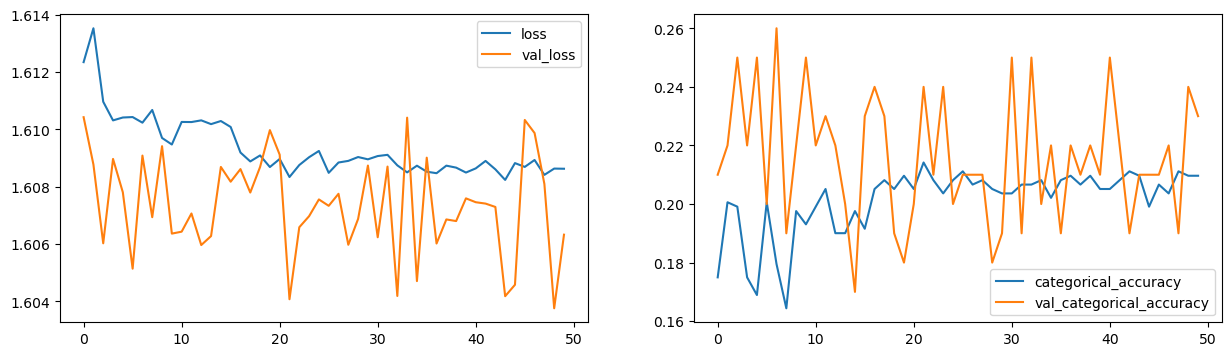

In [32]:
model = Model_2D_02(nb_classes = 5)
history = train_model(model, name = '2D_02')
plot_history(history)

Highest val_acc: at epoch 41: acc: 0.2051, val_acc: 0.2500

### 2.2.3 Another custom 2D CNN +GRU

In [37]:
def Model_2D_03(nb_classes):
    """
        Another custom CNN with GRU
    """
    nb_classes = nb_classes
    input_shape = (15, 128, 128, 3)
    model = Sequential(name = "2D_03")

    model.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    model.add(Dropout(0.25))

    model.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    model.add(Dropout(0.25))

    model.add(TimeDistributed(Conv2D(128, (2,2),padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.25))

    ## using GRU as the RNN model along with softmax as our last layer.
    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.25))

    # using Softmax as last layer
    model.add(Dense(nb_classes, activation='softmax')) 
    return model

###############################################
Model 2D_03 summary
Model: "2D_03"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 15, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 15, 64, 64, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 15, 32, 32, 16)   0         
 stributed)                                                      
                                                                 
 dropout_14 (Dropout)        (None, 15, 32, 32, 16)    0         
                                                                 
 time_distributed_67 (TimeDi  (None, 15, 32, 32, 32)   4640

83/83 [==============================] - 19s 228ms/step - loss: 0.5276 - categorical_accuracy: 0.9170 - val_loss: 1.0799 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 12/50
83/83 [==============================] - ETA: 0s - loss: 0.5017 - categorical_accuracy: 0.9351
Epoch 12: val_loss did not improve from 1.07988
83/83 [==============================] - 18s 223ms/step - loss: 0.5017 - categorical_accuracy: 0.9351 - val_loss: 2.0353 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 13/50
83/83 [==============================] - ETA: 0s - loss: 0.4310 - categorical_accuracy: 0.9336
Epoch 13: val_loss did not improve from 1.07988
83/83 [==============================] - 18s 221ms/step - loss: 0.4310 - categorical_accuracy: 0.9336 - val_loss: 1.9929 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 14/50
83/83 [==============================] - ETA: 0s - loss: 0.4622 - categorical_accuracy: 0.9291
Epoch 14: val_loss did not improve from 1.07988
83/83 [=====================

83/83 [==============================] - ETA: 0s - loss: 0.2529 - categorical_accuracy: 0.9638
Epoch 36: val_loss did not improve from 0.67197
83/83 [==============================] - 18s 221ms/step - loss: 0.2529 - categorical_accuracy: 0.9638 - val_loss: 0.8063 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 37/50
83/83 [==============================] - ETA: 0s - loss: 0.2238 - categorical_accuracy: 0.9789
Epoch 37: val_loss did not improve from 0.67197
83/83 [==============================] - 18s 222ms/step - loss: 0.2238 - categorical_accuracy: 0.9789 - val_loss: 1.5175 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 38/50
83/83 [==============================] - ETA: 0s - loss: 0.2359 - categorical_accuracy: 0.9713
Epoch 38: val_loss improved from 0.67197 to 0.59525, saving model to ./checkpoints\model_2D_03\model_2D_03-00038-0.23594-0.97134-0.59525-0.85000.h5
83/83 [==============================] - 18s 224ms/step - loss: 0.2359 - categorical_accuracy: 0.9713 - val_l

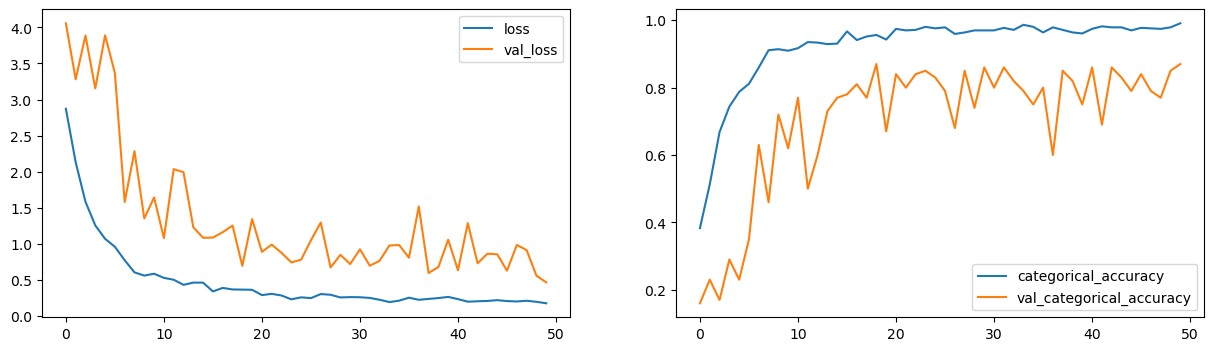

In [38]:
model = Model_2D_03(nb_classes = 5)
history = train_model(model, name = '2D_03')
plot_history(history)

Highest val_acc: at epoch 50: acc: 0.9910, val_acc: 0.8700

## 2.3 Pretrained model with LSTM/GRU

### 2.3.1 VGG16 + GRU

In [39]:
def Model_Pretrained_01(nb_classes):
    """
        VGG 16 + GRU
    """
    input_shape = (15, 128, 128, 3)
    weight_decay = 0.005
    nb_classes = nb_classes
    
    # load VGG16 and freeze it
    vgg_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', 
                                                  include_top=False, 
                                                  input_shape=(dest_size[0], dest_size[1], 3))
    vgg_model.trainable = False
    

    model = Sequential(name="Pretrained_01")
    model.add(TimeDistributed(vgg_model,input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))


    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    # using Softmax as last layer
    model.add(Dense(nb_classes, activation='softmax')) 
    
    return model

###############################################
Model Pretrained_01 summary
Model: "Pretrained_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_77 (TimeDi  (None, 15, 4, 4, 512)    14714688  
 stributed)                                                      
                                                                 
 time_distributed_78 (TimeDi  (None, 15, 4, 4, 512)    2048      
 stributed)                                                      
                                                                 
 time_distributed_79 (TimeDi  (None, 15, 2, 2, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_80 (TimeDi  (None, 15, 2048)         0         
 stributed)                                                      
                                           

Epoch 18/50
83/83 [==============================] - ETA: 0s - loss: 0.1120 - categorical_accuracy: 0.9804
Epoch 18: val_loss did not improve from 0.50396
83/83 [==============================] - 19s 225ms/step - loss: 0.1120 - categorical_accuracy: 0.9804 - val_loss: 0.8529 - val_categorical_accuracy: 0.7900 - lr: 1.0000e-04
Epoch 19/50
83/83 [==============================] - ETA: 0s - loss: 0.1263 - categorical_accuracy: 0.9819
Epoch 19: val_loss improved from 0.50396 to 0.49011, saving model to ./checkpoints\model_Pretrained_01\model_Pretrained_01-00019-0.12629-0.98190-0.49011-0.88000.h5
83/83 [==============================] - 19s 230ms/step - loss: 0.1263 - categorical_accuracy: 0.9819 - val_loss: 0.4901 - val_categorical_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 20/50
83/83 [==============================] - ETA: 0s - loss: 0.1220 - categorical_accuracy: 0.9819
Epoch 20: val_loss did not improve from 0.49011
83/83 [==============================] - 19s 227ms/step - loss: 0.1220 - 

83/83 [==============================] - 23s 284ms/step - loss: 0.1005 - categorical_accuracy: 0.9879 - val_loss: 0.5594 - val_categorical_accuracy: 0.8700 - lr: 1.0000e-05
Epoch 43/50
83/83 [==============================] - ETA: 0s - loss: 0.0954 - categorical_accuracy: 0.9894
Epoch 43: val_loss did not improve from 0.49011
83/83 [==============================] - 19s 228ms/step - loss: 0.0954 - categorical_accuracy: 0.9894 - val_loss: 0.7415 - val_categorical_accuracy: 0.8400 - lr: 1.0000e-05
Epoch 44/50
83/83 [==============================] - ETA: 0s - loss: 0.0904 - categorical_accuracy: 0.9879
Epoch 44: val_loss did not improve from 0.49011

Epoch 44: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
83/83 [==============================] - 19s 227ms/step - loss: 0.0904 - categorical_accuracy: 0.9879 - val_loss: 0.8652 - val_categorical_accuracy: 0.8200 - lr: 1.0000e-05
Epoch 45/50
83/83 [==============================] - ETA: 0s - loss: 0.1003 - categorical_ac

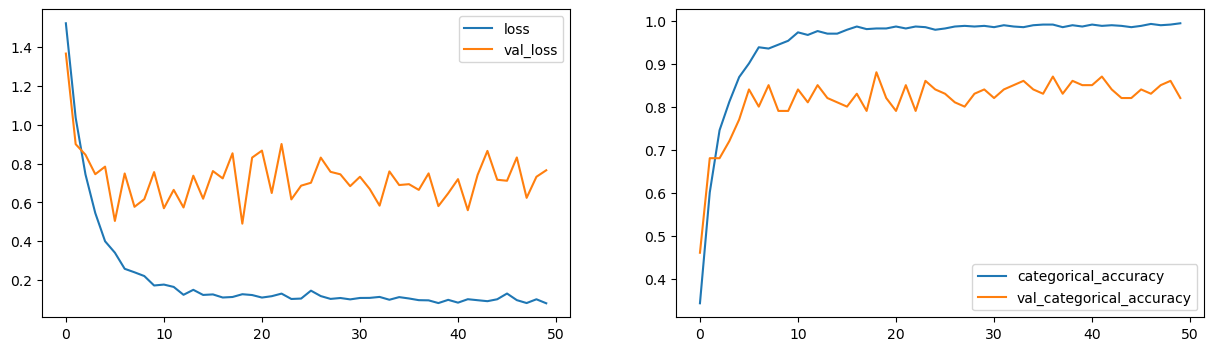

In [40]:
model = Model_Pretrained_01(nb_classes = 5)
history = train_model(model, name = 'Pretrained_01')
plot_history(history)

Highest val_acc: at epoch 49: acc: 0.9910, val_acc: 0.8600

### 2.3.2 ResNet50 + GRU

In [41]:
def Model_Pretrained_02(nb_classes):
    """
        ResNet50 + GRU
    """
    input_shape = (15, 128, 128, 3)
    weight_decay = 0.005
    nb_classes = nb_classes
    
    # load ResNet50 and freeze it
    resnet50_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', 
                                                       include_top=False, 
                                                       input_shape=(dest_size[0], dest_size[1], 3))
    resnet50_model.trainable = False

    model = Sequential(name="Pretrained_02")
    model.add(TimeDistributed(resnet50_model,input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))


    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    # using Softmax as last layer
    model.add(Dense(nb_classes, activation='softmax')) 
    
    return model

###############################################
Model Pretrained_02 summary
Model: "Pretrained_02"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_81 (TimeDi  (None, 15, 4, 4, 512)    14714688  
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 15, 4, 4, 512)    2048      
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 15, 2, 2, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 15, 2048)         0         
 stributed)                                                      
                                           

Epoch 18/50
83/83 [==============================] - ETA: 0s - loss: 0.0919 - categorical_accuracy: 0.9894
Epoch 18: val_loss did not improve from 0.49767
83/83 [==============================] - 19s 228ms/step - loss: 0.0919 - categorical_accuracy: 0.9894 - val_loss: 0.6403 - val_categorical_accuracy: 0.8300 - lr: 1.0000e-04
Epoch 19/50
83/83 [==============================] - ETA: 0s - loss: 0.1070 - categorical_accuracy: 0.9774
Epoch 19: val_loss did not improve from 0.49767
83/83 [==============================] - 19s 228ms/step - loss: 0.1070 - categorical_accuracy: 0.9774 - val_loss: 0.6846 - val_categorical_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 20/50
83/83 [==============================] - ETA: 0s - loss: 0.0965 - categorical_accuracy: 0.9879
Epoch 20: val_loss did not improve from 0.49767
83/83 [==============================] - 19s 228ms/step - loss: 0.0965 - categorical_accuracy: 0.9879 - val_loss: 0.7560 - val_categorical_accuracy: 0.8100 - lr: 1.0000e-04
Epoch 21/50
83/8

Epoch 43/50
83/83 [==============================] - ETA: 0s - loss: 0.0864 - categorical_accuracy: 0.9864
Epoch 43: val_loss did not improve from 0.49767
83/83 [==============================] - 19s 225ms/step - loss: 0.0864 - categorical_accuracy: 0.9864 - val_loss: 0.7614 - val_categorical_accuracy: 0.8200 - lr: 1.0000e-05
Epoch 44/50
83/83 [==============================] - ETA: 0s - loss: 0.1046 - categorical_accuracy: 0.9849
Epoch 44: val_loss did not improve from 0.49767

Epoch 44: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
83/83 [==============================] - 19s 225ms/step - loss: 0.1046 - categorical_accuracy: 0.9849 - val_loss: 0.8968 - val_categorical_accuracy: 0.7700 - lr: 1.0000e-05
Epoch 45/50
83/83 [==============================] - ETA: 0s - loss: 0.1047 - categorical_accuracy: 0.9910
Epoch 45: val_loss did not improve from 0.49767
83/83 [==============================] - 19s 226ms/step - loss: 0.1047 - categorical_accuracy: 0.9910 - val_lo

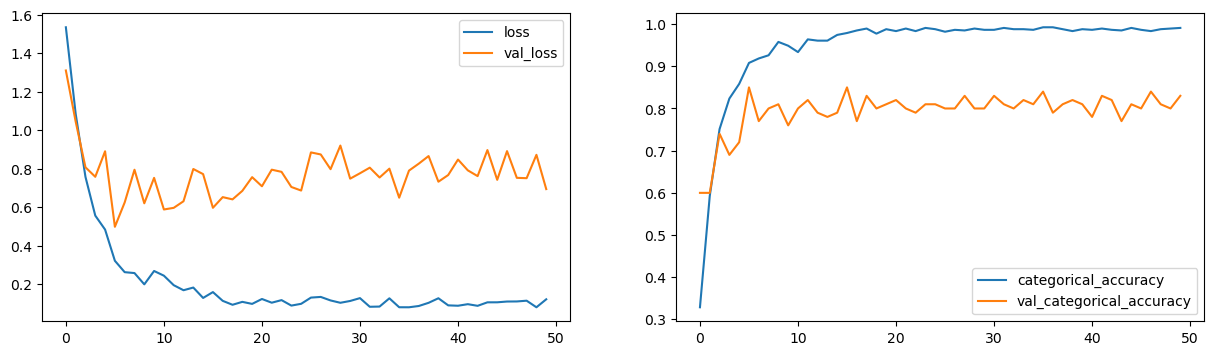

In [42]:
model = Model_Pretrained_02(nb_classes = 5)
history = train_model(model, name = 'Pretrained_02')
plot_history(history)

Highest val_acc: at epoch 50: acc: 0.9910, val_acc: 0.8300

### 2.3.3 EfficientNetv2B0 + GRU

In [43]:
def Model_Pretrained_03(nb_classes):
    """
        ResNet50 + GRU
    """
    input_shape = (15, 128, 128, 3)
    weight_decay = 0.005
    nb_classes = nb_classes
    
    # load EfficientNetv2B0 and freeze it
    eff_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(weights='imagenet', 
                                                                       include_top=False, 
                                                                       input_shape=(dest_size[0], dest_size[1], 3))
    eff_model.trainable = False

    model = Sequential(name="Pretrained_03")
    model.add(TimeDistributed(eff_model,input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))


    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    # using Softmax as last layer
    model.add(Dense(nb_classes, activation='softmax')) 
    
    return model

###############################################
Model Pretrained_03 summary
Model: "Pretrained_03"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_85 (TimeDi  (None, 15, 4, 4, 1280)   5919312   
 stributed)                                                      
                                                                 
 time_distributed_86 (TimeDi  (None, 15, 4, 4, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_87 (TimeDi  (None, 15, 2, 2, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_88 (TimeDi  (None, 15, 5120)         0         
 stributed)                                                      
                                           

83/83 [==============================] - ETA: 0s - loss: 1.6091 - categorical_accuracy: 0.2157
Epoch 18: val_loss did not improve from 1.60699
83/83 [==============================] - 19s 229ms/step - loss: 1.6091 - categorical_accuracy: 0.2157 - val_loss: 1.6093 - val_categorical_accuracy: 0.1500 - lr: 1.0000e-04
Epoch 19/50
83/83 [==============================] - ETA: 0s - loss: 1.6142 - categorical_accuracy: 0.1900
Epoch 19: val_loss did not improve from 1.60699
83/83 [==============================] - 19s 233ms/step - loss: 1.6142 - categorical_accuracy: 0.1900 - val_loss: 1.6095 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 20/50
83/83 [==============================] - ETA: 0s - loss: 1.6121 - categorical_accuracy: 0.2142
Epoch 20: val_loss did not improve from 1.60699
83/83 [==============================] - 19s 230ms/step - loss: 1.6121 - categorical_accuracy: 0.2142 - val_loss: 1.6080 - val_categorical_accuracy: 0.1900 - lr: 1.0000e-04
Epoch 21/50
83/83 [=========


Epoch 42: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
83/83 [==============================] - 19s 233ms/step - loss: 1.6095 - categorical_accuracy: 0.2127 - val_loss: 1.6103 - val_categorical_accuracy: 0.1800 - lr: 1.0000e-05
Epoch 43/50
83/83 [==============================] - ETA: 0s - loss: 1.6093 - categorical_accuracy: 0.1976
Epoch 43: val_loss did not improve from 1.60665
83/83 [==============================] - 19s 230ms/step - loss: 1.6093 - categorical_accuracy: 0.1976 - val_loss: 1.6080 - val_categorical_accuracy: 0.1800 - lr: 1.0000e-06
Epoch 44/50
83/83 [==============================] - ETA: 0s - loss: 1.6103 - categorical_accuracy: 0.2097
Epoch 44: val_loss did not improve from 1.60665
83/83 [==============================] - 19s 234ms/step - loss: 1.6103 - categorical_accuracy: 0.2097 - val_loss: 1.6083 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-06
Epoch 45/50
83/83 [==============================] - ETA: 0s - loss: 1.6061 - categorical_ac

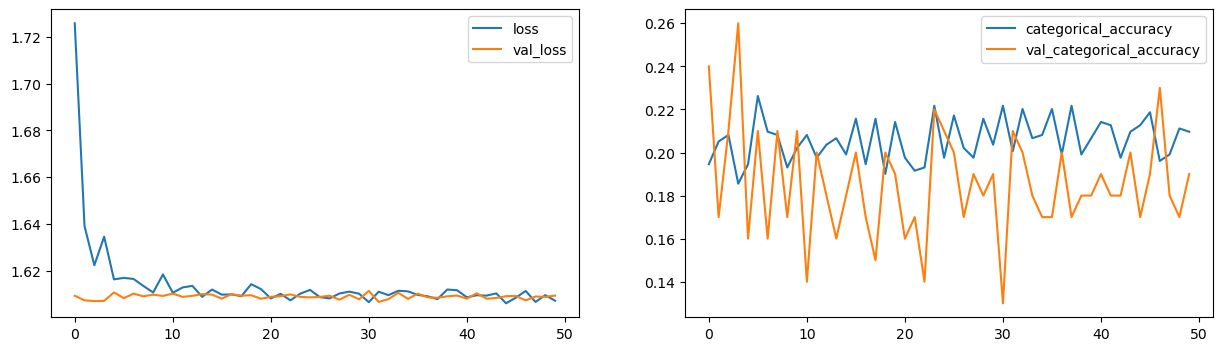

In [44]:
model = Model_Pretrained_03(nb_classes = 5)
history = train_model(model, name = 'Pretrained_03')
plot_history(history)

Highest val_acc: at epoch 46: acc: 0.1961, val_acc: 0.2300

### 2.3.4 EfficientNetv2B1 + GRU

In [45]:
def Model_Pretrained_04(nb_classes):
    """
        ResNet50 + GRU
    """
    input_shape = (15, 128, 128, 3)
    weight_decay = 0.005
    nb_classes = nb_classes
    
    # load EfficientNetv2B1 and freeze it
    eff_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(weights='imagenet', 
                                                                       include_top=False, 
                                                                       input_shape=(dest_size[0], dest_size[1], 3))
    eff_model.trainable = False

    model = Sequential(name="Pretrained_04")
    model.add(TimeDistributed(eff_model,input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))


    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    # using Softmax as last layer
    model.add(Dense(nb_classes, activation='softmax')) 
    
    return model

###############################################
Model Pretrained_04 summary
Model: "Pretrained_04"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_89 (TimeDi  (None, 15, 4, 4, 1280)   6931124   
 stributed)                                                      
                                                                 
 time_distributed_90 (TimeDi  (None, 15, 4, 4, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_91 (TimeDi  (None, 15, 2, 2, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_92 (TimeDi  (None, 15, 5120)         0         
 stributed)                                                      
                                           

Epoch 18/50
83/83 [==============================] - ETA: 0s - loss: 1.6099 - categorical_accuracy: 0.2112
Epoch 18: val_loss did not improve from 1.60311
83/83 [==============================] - 19s 232ms/step - loss: 1.6099 - categorical_accuracy: 0.2112 - val_loss: 1.6064 - val_categorical_accuracy: 0.1900 - lr: 1.0000e-04
Epoch 19/50
83/83 [==============================] - ETA: 0s - loss: 1.6056 - categorical_accuracy: 0.2081
Epoch 19: val_loss did not improve from 1.60311
83/83 [==============================] - 23s 275ms/step - loss: 1.6056 - categorical_accuracy: 0.2081 - val_loss: 1.6089 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 20/50
83/83 [==============================] - ETA: 0s - loss: 1.6118 - categorical_accuracy: 0.2021
Epoch 20: val_loss did not improve from 1.60311
83/83 [==============================] - 49s 595ms/step - loss: 1.6118 - categorical_accuracy: 0.2021 - val_loss: 1.6072 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04
Epoch 21/50
83/8

Epoch 43/50
83/83 [==============================] - ETA: 0s - loss: 1.6084 - categorical_accuracy: 0.2021
Epoch 43: val_loss did not improve from 1.60311

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
83/83 [==============================] - 19s 228ms/step - loss: 1.6084 - categorical_accuracy: 0.2021 - val_loss: 1.6073 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-05
Epoch 44/50
83/83 [==============================] - ETA: 0s - loss: 1.6103 - categorical_accuracy: 0.1976
Epoch 44: val_loss did not improve from 1.60311
83/83 [==============================] - 18s 224ms/step - loss: 1.6103 - categorical_accuracy: 0.1976 - val_loss: 1.6056 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-06
Epoch 45/50
83/83 [==============================] - ETA: 0s - loss: 1.6084 - categorical_accuracy: 0.2127
Epoch 45: val_loss did not improve from 1.60311
83/83 [==============================] - 19s 228ms/step - loss: 1.6084 - categorical_accuracy: 0.2127 - val_lo

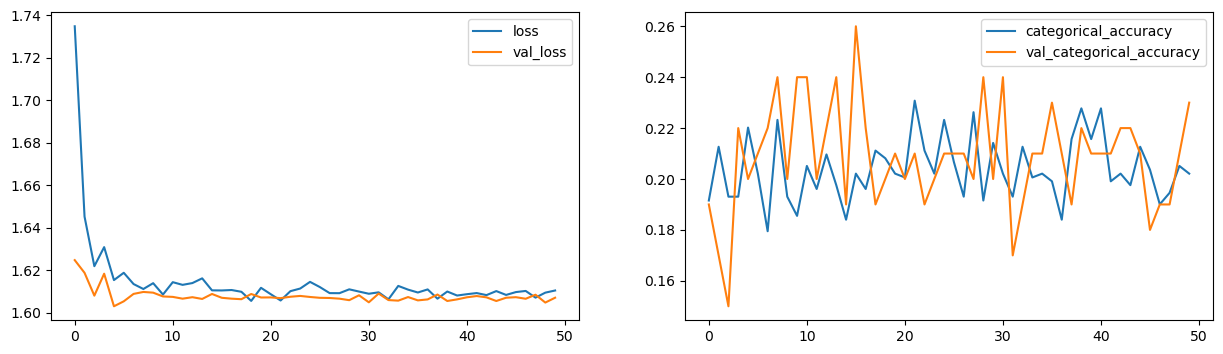

In [46]:
model = Model_Pretrained_04(nb_classes = 5)
history = train_model(model, name = 'Pretrained_04')
plot_history(history)

Highest val_acc: at epoch 16: acc: 0.2021, val_acc: 0.2600

### 2.3.5 MobileNetv2 + GRU

In [47]:
def Model_Pretrained_05(nb_classes):
    """
        MobileNetv2 + GRU
    """
    input_shape = (15, dest_size[0], dest_size[1], 3)
    weight_decay = 0.005
    nb_classes = nb_classes
    
    # load MobileNetv2 and freeze it
    mob_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                                                               include_top=False, 
                                                               input_shape=(dest_size[0], dest_size[1], 3))
    mob_model.trainable = False
    model = Sequential(name="Pretrained_05")
    model.add(TimeDistributed(mob_model,input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))


    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    # using Softmax as last layer
    model.add(Dense(nb_classes, activation='softmax')) 
    
    return model

###############################################
Model Pretrained_05 summary
Model: "Pretrained_05"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_93 (TimeDi  (None, 15, 4, 4, 1280)   2257984   
 stributed)                                                      
                                                                 
 time_distributed_94 (TimeDi  (None, 15, 4, 4, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_95 (TimeDi  (None, 15, 2, 2, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_96 (TimeDi  (None, 15, 5120)         0         
 stributed)                                                      
                                           

33/34 [============================>.] - ETA: 0s - loss: 0.1096 - categorical_accuracy: 0.9758
Epoch 17: val_loss did not improve from 0.28994
34/34 [==============================] - 20s 592ms/step - loss: 0.1232 - categorical_accuracy: 0.9729 - val_loss: 0.4645 - val_categorical_accuracy: 0.8300 - lr: 0.0010
Epoch 18/50
33/34 [============================>.] - ETA: 0s - loss: 0.1108 - categorical_accuracy: 0.9712
Epoch 18: val_loss did not improve from 0.28994
34/34 [==============================] - 19s 583ms/step - loss: 0.1253 - categorical_accuracy: 0.9683 - val_loss: 0.3913 - val_categorical_accuracy: 0.8600 - lr: 0.0010
Epoch 19/50
33/34 [============================>.] - ETA: 0s - loss: 0.0867 - categorical_accuracy: 0.9879
Epoch 19: val_loss did not improve from 0.28994
34/34 [==============================] - 19s 574ms/step - loss: 0.1231 - categorical_accuracy: 0.9834 - val_loss: 0.5063 - val_categorical_accuracy: 0.8200 - lr: 0.0010
Epoch 20/50
33/34 [=====================

Epoch 42/50
33/34 [============================>.] - ETA: 0s - loss: 0.0620 - categorical_accuracy: 0.9894
Epoch 42: val_loss did not improve from 0.28994
34/34 [==============================] - 18s 555ms/step - loss: 0.0866 - categorical_accuracy: 0.9849 - val_loss: 0.4685 - val_categorical_accuracy: 0.8400 - lr: 1.0000e-05
Epoch 43/50
33/34 [============================>.] - ETA: 0s - loss: 0.0558 - categorical_accuracy: 0.9939
Epoch 43: val_loss did not improve from 0.28994
34/34 [==============================] - 18s 548ms/step - loss: 0.0731 - categorical_accuracy: 0.9910 - val_loss: 0.5359 - val_categorical_accuracy: 0.8100 - lr: 1.0000e-05
Epoch 44/50
33/34 [============================>.] - ETA: 0s - loss: 0.0671 - categorical_accuracy: 0.9864
Epoch 44: val_loss did not improve from 0.28994
34/34 [==============================] - 18s 552ms/step - loss: 0.0937 - categorical_accuracy: 0.9819 - val_loss: 0.5197 - val_categorical_accuracy: 0.8400 - lr: 1.0000e-05
Epoch 45/50
33/3

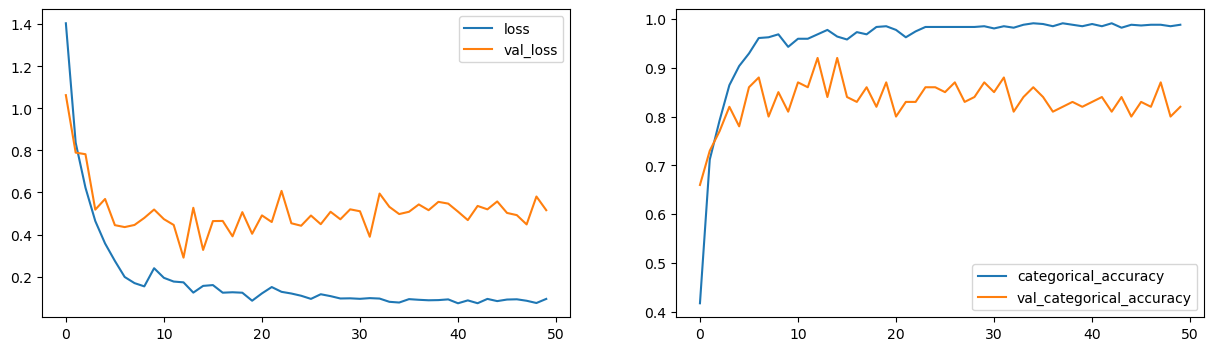

In [48]:
model = Model_Pretrained_05(nb_classes = 5)
history = train_model(model, name = 'Pretrained_05', batch_size=20)
plot_history(history)

Highest val_acc: at epoch 15: acc: 0.9638, val_acc: 0.9200

### 2.3.6 Xception + GRU

In [49]:
def Model_Pretrained_06(nb_classes):
    """
        Xception + GRU
    """
    input_shape = (15, dest_size[0], dest_size[1], 3)
    weight_decay = 0.005
    nb_classes = nb_classes
    
    # load MobileNetv2 and freeze it
    xcep_model = tf.keras.applications.xception.Xception(weights='imagenet',
                                                        include_top=False, 
                                                        input_shape=(dest_size[0], dest_size[1], 3))
    xcep_model.trainable = False 
    
    model = Sequential(name="Pretrained_06")
    model.add(TimeDistributed(xcep_model,input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))


    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    # using Softmax as last layer
    model.add(Dense(nb_classes, activation='softmax')) 
    
    return model

###############################################
Model Pretrained_06 summary
Model: "Pretrained_06"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_97 (TimeDi  (None, 15, 4, 4, 2048)   20861480  
 stributed)                                                      
                                                                 
 time_distributed_98 (TimeDi  (None, 15, 4, 4, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_99 (TimeDi  (None, 15, 2, 2, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_100 (TimeD  (None, 15, 8192)         0         
 istributed)                                                     
                                           

83/83 [==============================] - ETA: 0s - loss: 0.4900 - categorical_accuracy: 0.8265
Epoch 17: val_loss did not improve from 0.78321
83/83 [==============================] - 19s 234ms/step - loss: 0.4900 - categorical_accuracy: 0.8265 - val_loss: 0.9195 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 18/50
83/83 [==============================] - ETA: 0s - loss: 0.4742 - categorical_accuracy: 0.8341
Epoch 18: val_loss did not improve from 0.78321
83/83 [==============================] - 19s 234ms/step - loss: 0.4742 - categorical_accuracy: 0.8341 - val_loss: 0.7955 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 19/50
83/83 [==============================] - ETA: 0s - loss: 0.4687 - categorical_accuracy: 0.8401
Epoch 19: val_loss did not improve from 0.78321
83/83 [==============================] - 19s 229ms/step - loss: 0.4687 - categorical_accuracy: 0.8401 - val_loss: 0.9999 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 20/50
83/83 [=====================

83/83 [==============================] - ETA: 0s - loss: 0.2655 - categorical_accuracy: 0.9201
Epoch 41: val_loss did not improve from 0.73637
83/83 [==============================] - 19s 233ms/step - loss: 0.2655 - categorical_accuracy: 0.9201 - val_loss: 1.0334 - val_categorical_accuracy: 0.6700 - lr: 1.0000e-05
Epoch 42/50
83/83 [==============================] - ETA: 0s - loss: 0.2861 - categorical_accuracy: 0.9216
Epoch 42: val_loss did not improve from 0.73637
83/83 [==============================] - 19s 237ms/step - loss: 0.2861 - categorical_accuracy: 0.9216 - val_loss: 1.0591 - val_categorical_accuracy: 0.6400 - lr: 1.0000e-05
Epoch 43/50
83/83 [==============================] - ETA: 0s - loss: 0.2907 - categorical_accuracy: 0.9351
Epoch 43: val_loss did not improve from 0.73637
83/83 [==============================] - 19s 232ms/step - loss: 0.2907 - categorical_accuracy: 0.9351 - val_loss: 0.8409 - val_categorical_accuracy: 0.6700 - lr: 1.0000e-05
Epoch 44/50
83/83 [=========

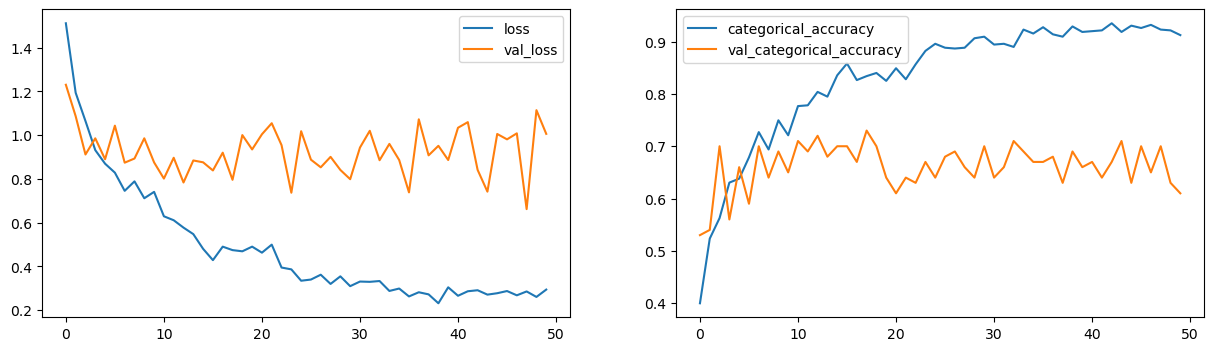

In [50]:
model = Model_Pretrained_06(nb_classes = 5)
history = train_model(model, name = 'Pretrained_06', batch_size=8)
plot_history(history)

Highest val_acc: at epoch 48: acc: 0.9231, val_acc: 0.7000

### 2.3.7 MobilenetV2 + LSTM
We found that Mobilenet + GRU is the best model amond all the models we trained, now try mobilenet + LSTM

In [51]:
def Model_Pretrained_07(nb_classes):
    """
        MobileNetv2 + GRU
    """
    input_shape = (15, dest_size[0], dest_size[1], 3)
    weight_decay = 0.005
    nb_classes = nb_classes
    
    # load MobileNetv2 and freeze it
    mob_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                                                               include_top=False, 
                                                               input_shape=(dest_size[0], dest_size[1], 3))
    mob_model.trainable = False
    model = Sequential(name="Pretrained_07")
    model.add(TimeDistributed(mob_model,input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))


    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    # using Softmax as last layer
    model.add(Dense(nb_classes, activation='softmax')) 
    
    return model

###############################################
Model Pretrained_07 summary
Model: "Pretrained_07"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_101 (TimeD  (None, 15, 4, 4, 1280)   2257984   
 istributed)                                                     
                                                                 
 time_distributed_102 (TimeD  (None, 15, 4, 4, 1280)   5120      
 istributed)                                                     
                                                                 
 time_distributed_103 (TimeD  (None, 15, 2, 2, 1280)   0         
 istributed)                                                     
                                                                 
 time_distributed_104 (TimeD  (None, 15, 5120)         0         
 istributed)                                                     
                                           

166/166 [==============================] - ETA: 0s - loss: 0.1238 - categorical_accuracy: 0.9698
Epoch 17: val_loss improved from 0.38440 to 0.37460, saving model to ./checkpoints\model_Pretrained_07\model_Pretrained_07-00017-0.12383-0.96983-0.37460-0.90000.h5
166/166 [==============================] - 19s 117ms/step - loss: 0.1238 - categorical_accuracy: 0.9698 - val_loss: 0.3746 - val_categorical_accuracy: 0.9000 - lr: 0.0010
Epoch 18/50
166/166 [==============================] - ETA: 0s - loss: 0.0977 - categorical_accuracy: 0.9774
Epoch 18: val_loss did not improve from 0.37460
166/166 [==============================] - 19s 118ms/step - loss: 0.0977 - categorical_accuracy: 0.9774 - val_loss: 0.5214 - val_categorical_accuracy: 0.8500 - lr: 0.0010
Epoch 19/50
166/166 [==============================] - ETA: 0s - loss: 0.1035 - categorical_accuracy: 0.9819
Epoch 19: val_loss did not improve from 0.37460
166/166 [==============================] - 20s 118ms/step - loss: 0.1035 - categori

Epoch 41/50
165/166 [============================>.] - ETA: 0s - loss: 0.0377 - categorical_accuracy: 0.9894
Epoch 41: val_loss did not improve from 0.37019
166/166 [==============================] - 19s 116ms/step - loss: 0.0515 - categorical_accuracy: 0.9879 - val_loss: 0.5142 - val_categorical_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 42/50
166/166 [==============================] - ETA: 0s - loss: 0.0520 - categorical_accuracy: 0.9910
Epoch 42: val_loss did not improve from 0.37019
166/166 [==============================] - 19s 118ms/step - loss: 0.0520 - categorical_accuracy: 0.9910 - val_loss: 0.5389 - val_categorical_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 43/50
166/166 [==============================] - ETA: 0s - loss: 0.0734 - categorical_accuracy: 0.9940
Epoch 43: val_loss did not improve from 0.37019
166/166 [==============================] - 19s 116ms/step - loss: 0.0734 - categorical_accuracy: 0.9940 - val_loss: 0.5169 - val_categorical_accuracy: 0.8900 - lr: 1.0000e-04
Epoc

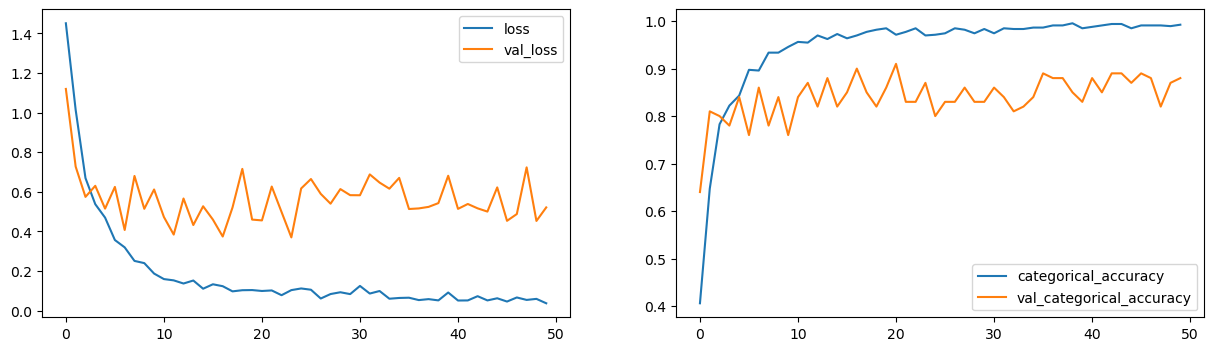

In [52]:
model = Model_Pretrained_07(nb_classes = 5)
history = train_model(model, name = 'Pretrained_07', batch_size=4)
plot_history(history)

Highest val_acc: at epoch 46: acc: 0.9759, val_acc: 0.8600

## 3. Conclusion

Best model for val_acc is pretrained MobileNetv2 + LSTM, about % for acc

If you on edge device, we can chooise model CNN_03, because it only have total 200000 para, very light weight but still good enough (87% val acc)

For further improvement, we may need more data, data augmentation, larger batch_size